In [20]:
# Importa las librerias requeridas para el proyecto
import numpy as np
import tensorflow as tf
import sionna

In [21]:
# Parametros del sistema
N = 1024 # longitud del código
K = 512 # número de bits de información (antes de CRC)
coderate = K/N # tasa del código
bitsxsimb = 2 # bits por símbolo (QPSK)
EBNO_DB_MIN = 0
EBNO_DB_MAX = 15
LOTE = 100 # tamaño de lote para ploteo

In [ ]:
class SinCodigCanalRayleigh(sionna.phy.Block):
    def __init__(self, N, bitsxsimb=2):
        super().__init__()
        self.bitsxsimb = bitsxsimb
        self.N = N
        
        # Inicializa los bloques necesarios
        self.datos = sionna.phy.mapping.BinarySource()
        self.constelacion = sionna.phy.mapping.Constellation("qam", bitsxsimb)
        self.mapeador = sionna.phy.mapping.Mapper(constellation=self.constelacion)
        self.demapeador = sionna.phy.mapping.Demapper("app", constellation=self.constelacion)
        self.generador_rayleigh = sionna.phy.channel.GenerateFlatFadingChannel(num_tx_ant=1, num_rx_ant=1)
        self.awgn = sionna.phy.channel.AWGN() # Se añade luego de aplicar fading plano
        
    def call(self, batch_size, ebno_db):
        # Codificación
        b = self.datos([batch_size, self.N])

        # Mapeo
        x = self.mapeador(b)
        
        # Canal Rayleigh plano + AWGN
        no = sionna.phy.utils.ebnodb2no(ebno_db, self.bitsxsimb, coderate=1.0)
        no_c = tf.cast(no, tf.complex64)
        h = self.generador_rayleigh(batch_size)
        h_plano = tf.squeeze(h, axis=[1,2])
        y_pre = tf.expand_dims(h_plano, -1) * x
        y = self.awgn(y_pre, no)

        # Ecualizador ZF
        abs_h2_c = tf.cast(tf.abs(h_plano)**2, tf.complex64)
        zf = tf.math.conj(h_plano) / abs_h2_c
        x_eq = tf.expand_dims(zf, -1) * y

        # Varianza efectiva del ruido
        no_eff = no_c / abs_h2_c
        no_eff_real = tf.cast(tf.math.real(no_eff), tf.float32)
        no_eff_broadcast = tf.ones_like(x_eq, dtype=tf.float32) * tf.expand_dims(no_eff_real, -1)

        # Demapeo LLR
        llr = self.demapeador(x_eq, no_eff_broadcast)

        return b, llr

In [23]:
# Se inicializa el sistema con los bits congelados aleatorios
canal_rayleigh = SinCodigCanalRayleigh(N, bitsxsimb=bitsxsimb)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.5517e-01 | 9.9500e-01 |       31779 |      204800 |          199 |         200 |         0.1 |reached target block errors
      1.0 | 1.2687e-01 | 1.0000e+00 |       12992 |      102400 |          100 |         100 |         0.0 |reached target block errors
      2.0 | 9.5767e-02 | 9.4500e-01 |       19613 |      204800 |          189 |         200 |         0.1 |reached target block errors
      3.0 | 8.0928e-02 | 9.0500e-01 |       16574 |      204800 |          181 |         200 |         0.1 |reached target block errors
      4.0 | 7.5742e-02 | 8.5500e-01 |       15512 |      204800 |          171 |         200 |         0.1 |reached target block errors
      5.0 | 6.0771e-02 | 7.7500e-01 |       12446 |      204800 |

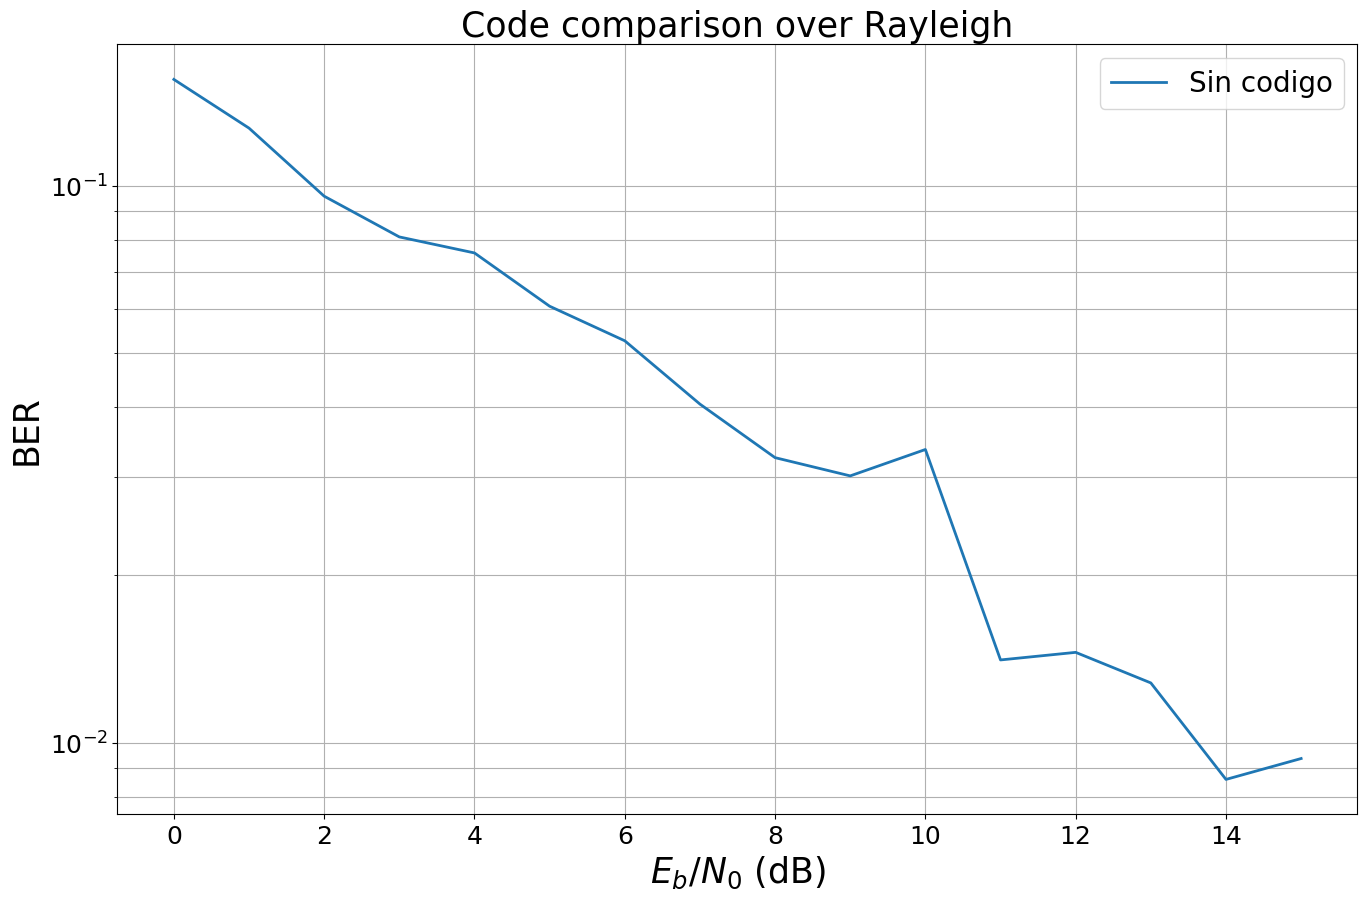

In [24]:
ber_plots = sionna.phy.utils.PlotBER("Code comparison over Rayleigh")
ber_plots.simulate(canal_rayleigh,
                   ebno_dbs=np.linspace(EBNO_DB_MIN, EBNO_DB_MAX, 16),
                   batch_size=LOTE,
                   num_target_block_errors=100,
                   legend="Sin codigo",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True);